In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

sns.set_style("whitegrid")

In [2]:
datasets = [pd.read_csv('data_01.csv'), pd.read_csv('data_02.csv'), pd.read_csv('data_03.csv'), pd.read_csv('data_04.csv'), pd.read_csv('data_05.csv'), pd.read_csv('data_06.csv')]

In [3]:
datasets

[            x          y
 0   13.344351   9.064982
 1   12.141748   9.742935
 2   16.045178  10.697097
 3    9.044173   7.119905
 4   16.597604  11.721995
 5   16.971541  11.084452
 6   14.969768   8.556869
 7   21.606183  13.944155
 8   18.667185  12.838265
 9   18.963388  11.528017
 10   9.848068   6.768517
 11  15.413508   9.262659
 12  17.040085  11.628427
 13  19.146494  13.196007
 14  17.403201  11.509638
 15  16.565045  12.837942
 16  15.564599   9.677147
 17  12.582256   7.641464
 18  15.108594   8.604779
 19  19.862395  13.495480
 20  12.341833   8.696986
 21  15.639664  10.381435
 22  20.770234  13.276503
 23  16.363313  12.019753
 24  14.540342   8.414521
 25  14.070328   9.311857
 26  17.326367  12.244820
 27  10.977430   8.489924
 28  18.279427  12.050934
 29  13.509779  10.136654
 30  16.918957  11.294113
 31  19.601131  12.120590
 32  11.606612   9.258319
 33  14.968256  11.087233
 34  14.035624   9.064145
 35  13.179063  10.414766
 36  14.616029  11.350486
 37  24.3231

In [4]:
all_data = pd.concat(datasets, keys=range(len(datasets)))
all_data['dataset_idx'] = np.repeat(range(len(datasets)), [len(df) for df in datasets])

M = len(datasets)
N = len(all_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [α_μ_tmp, α_σ_tmp, β_μ, β_σ, α_tmp, β, ε, ν]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 58 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


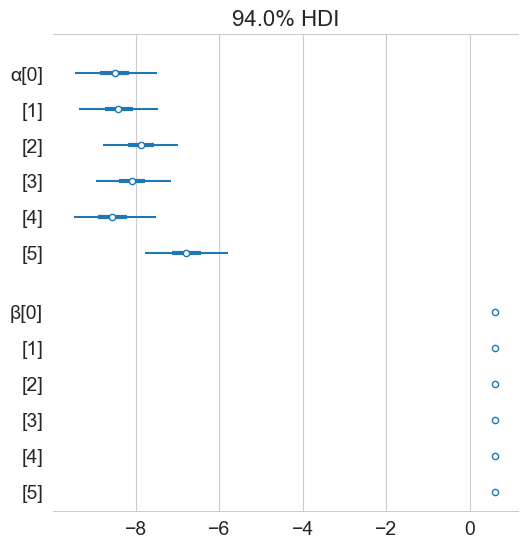

In [5]:
M = len(datasets)
N = len(all_data)
with pm.Model() as hierarchical_model:
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sigma=5)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', sigma=3)
    β_μ = pm.Normal('β_μ', mu=0, sigma=2)
    β_σ = pm.HalfNormal('β_σ', sigma=2)

    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sigma=α_σ_tmp, shape=len(datasets))
    β = pm.Normal('β', mu=β_μ, sigma=β_σ, shape=len(datasets))
    ε = pm.HalfCauchy('ε', 2)
    ν = pm.Normal('ν', 1/12)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[all_data['dataset_idx']] + β[all_data['dataset_idx']] * all_data['x'].values,
    sigma=ε, nu=ν, observed=all_data['y'].values)

    α = pm.Deterministic('α', α_tmp - β * all_data.groupby('dataset_idx').mean()['x'].values)
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * all_data.groupby('dataset_idx').mean()['x'].values)
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * all_data.groupby('dataset_idx').mean()['x'].values)

    trace_hm = pm.sample(1000, target_accept=0.95)

# Отобразите результаты
az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True);


In [6]:
az.summary(trace_hm)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α_μ_tmp,0.893,0.255,0.377,1.334,0.012,0.009,428.0,738.0,1.00
β_μ,0.609,0.016,0.580,0.641,0.001,0.001,399.0,675.0,1.00
α_tmp[0],0.996,0.270,0.497,1.513,0.013,0.009,433.0,917.0,1.00
α_tmp[1],0.974,0.271,0.510,1.528,0.013,0.009,412.0,795.0,1.00
α_tmp[2],0.816,0.253,0.352,1.273,0.013,0.009,403.0,711.0,1.00
α_tmp[3],0.879,0.255,0.396,1.355,0.012,0.009,432.0,785.0,1.00
α_tmp[4],0.741,0.271,0.257,1.273,0.013,0.009,438.0,737.0,1.00
α_tmp[5],0.960,0.352,0.332,1.621,0.014,0.010,642.0,1212.0,1.00
β[0],0.611,0.017,0.578,0.640,0.001,0.001,427.0,845.0,1.00
β[1],0.610,0.016,0.580,0.641,0.001,0.001,396.0,826.0,1.01


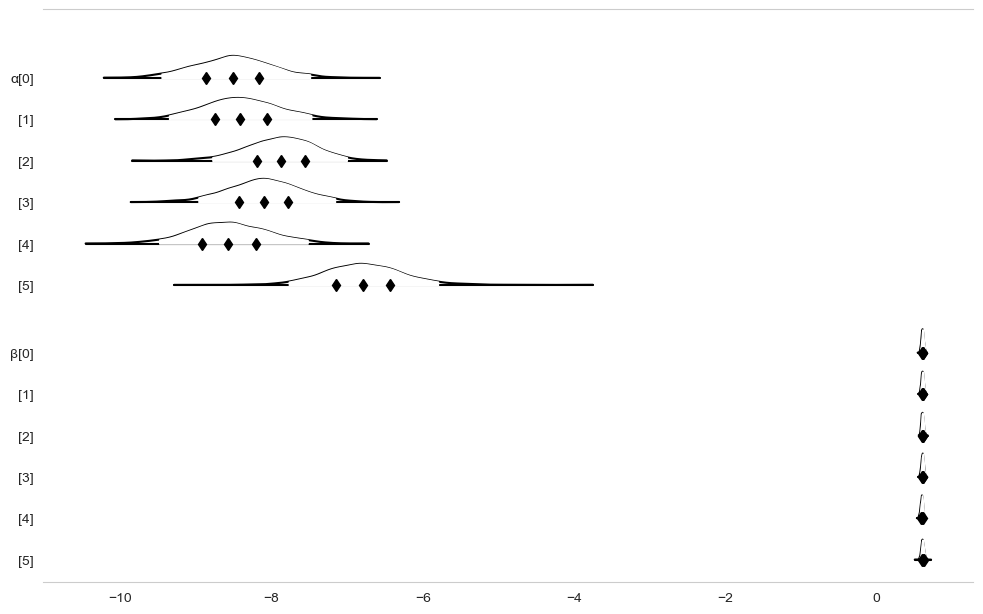

In [7]:
az.plot_forest(trace_hm, var_names=['α', 'β'],kind ='ridgeplot',
combined=True,
ridgeplot_truncate=False,
ridgeplot_quantiles=[.25, .5, .75],
ridgeplot_overlap=0.7,
colors='white');

In [8]:
all_data

x          y  dataset_idx
0 0   13.344351   9.064982            0
  1   12.141748   9.742935            0
  2   16.045178  10.697097            0
  3    9.044173   7.119905            0
  4   16.597604  11.721995            0
...         ...        ...          ...
4 44  16.883676  11.708367            4
  45  13.678907   8.130473            4
  46  14.441869  10.134124            4
5 0   13.252132   8.762344            5
  1   12.047335   9.439947            5

[262 rows x 3 columns]